# Human Protein Atlas Image Classification


Image classification of microscope slides based on mixed protein patterns.

### Project Description
The objective for this project is to determine the locations of protein organelles present in the microscope images. This breaks down into two parts: first, identifying the protein location (in general) from the image, and second,labelling each organelle within the protein.

In particular we aim to build a model that can reliably make predictions even when the images contain a mixture of different cell types with different morphologies. 

### Task 
The problem is a a multi-label image classification task. Each image containing a mixture of different cell types must be predicted for each of the 27 labels. 

The training images that was provided by the kaggle competition includes a train_csv file that contains a list of image ids with the identified protein labels. 


### Requirements

- keras
- tensorflow
- numpy
- pydot
- pandas
- OpenCV (opencv-python)

In [1]:
# libraries

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Input, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras import backend as K

from sklearn.preprocessing import MultiLabelBinarizer

import cv2                      # openCV image processing
import numpy as np              # linear algebra
import pandas as pd             # data processing
import pydot                    # graphing/visualization
import matplotlib.pyplot as plt # graphing/visualization

import os
import gc
import random
import csv

Using TensorFlow backend.


### Labels

In [2]:
NUCLEOPLASM                   = 0
NUCLEAR_MEMBRANE              = 1
NUCLEOLI                      = 2
NUCLEOLI_FIBRILLAR_CENTER     = 3
NUCLEAR_SPECKLES              = 4
NUCLEAR_BODIES                = 5
ENDOPLASMIC_RETICULUM         = 6
GOLGI_APPARATUS               = 7
PEROXISOMES                   = 8
ENDOSOMES                     = 9
LYSOSOMES                     = 10
INTERMEDIATE_FILAMENTS        = 11
ACTIN_FILAMENTS               = 12
FOCAL_ADHESION_SITES          = 13
MICROTUBULES                  = 14
MICROTUBULE_ENDS              = 15
CYTOKINETIC_BRIDGE            = 16
MITOTIC_SPINDLE               = 17
MICROTUBULE_ORGANIZING_CENTER = 18
CENTROSOME                    = 19
LIPID_DROPLETS                = 20
PLASMA_MEMBRANE               = 21
CELL_JUNCTIONS                = 22
MITOCHONDRIA                  = 23
AGGRESOME                     = 24
CYTOSOL                       = 25
CYTOPLASMIC_BODIES            = 26
RODS_AND_RINGS                = 27

### Some Constants

In [3]:
LABELS_DIR = 'dataset'
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
TRAIN_SUBSET_SIZE = 10 # Selection of images to train from (chosen at random, max size is 31072)
LEN_LABELS = 28

### Image Loading

The first step is to take our dataset and prepare it so that it's ready for our model.

Images are split into four filters/layers:
- **green**: the protein of interest
- **blue**: the nucleus
- **red**: the microtubules
- **yellow**: the endoplasmic reticulum

For this project we will mostly be interested in the **green** filter, which will be used to predict the label, while the other filters will be used as references.

In [4]:
# Get images by layer

# training set images
train_green  = [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR) if 'green'  in i]

# Select TRAIN_SUBSET_SIZE images from the training set at random
random.shuffle(train_green)
train_green = train_green[:TRAIN_SUBSET_SIZE]
train_green_ids = [i[:-10].replace((TRAIN_DIR+'/'),'') 
                       for i in train_green] # remove '_green.png' and '_green.tif'

# Retrieve the other three layers for our subset (NB: unsorted)
train_blue =   [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-9] in train_green_ids) and ('blue' in i))]
train_red =    [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-8] in train_green_ids) and ('red' in i))]
train_yellow = [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-11] in train_green_ids) and ('yellow' in i))]

# force garbage collection to make sure memory isn't wasted
gc.collect()

# test set images
test_green  = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'green'  in i]
test_blue   = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'blue'   in i]
test_red    = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'red'    in i]
test_yellow = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'yellow' in i]

In [5]:
# Testing the above by seeing if the IDs are the same

train_green.sort()
train_blue.sort()
train_red.sort()
train_yellow.sort()
#print(train_green, end='\n\n')
#print(train_blue, end='\n\n')
#print(train_red, end='\n\n')
#print(train_yellow, end='\n\n')

### Label Loading

Loading the labels from *train.csv*

In [6]:
train_labels = {} # dictionary with key = photo ID and entry = list of labels

# Get all the labels
with open('dataset/train.csv') as label_file:
  csvreader = csv.reader(label_file, delimiter=',', quotechar='|')
  for row in csvreader:
    if "Id" not in row[0]:
        # only take the ones that were taken in the Image Loading part
        if any(row[0] in x for x in train_green):
            train_labels[row[0]] = row[1:][0].split(' ') # labels are separated by spaces

### Image Preprocessing

#### One Hot Encoding

In [7]:
def one_hot_encode(train_tags):
    ''' Creates a one hot encoded dictionary of all labels for each pic'''
    encoded = dict()
  
    for key in train_tags.keys():
        # create empty vector
        encoding = np.zeros(LEN_LABELS, dtype='uint8')
        # mark 1 for each tag in the vector
        for tag in train_tags[key]:
            encoding[int(tag)] = 1
            
        encoded[key] = tuple(encoding)
  
    return encoded

#### Load into Pandas

In [8]:
ohe_labels = one_hot_encode(train_labels)
training_set = pd.DataFrame.from_dict(ohe_labels, orient='index')
training_set.index.name = "Photo ID"
training_set.reset_index()
training_set.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Photo ID,,,,,,,,,,,,,,,,,,,,,
15c32354-bbaa-11e8-b2ba-ac1f6b6435d0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2bf44f30-bba1-11e8-b2b9-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51c7ebd6-bbab-11e8-b2ba-ac1f6b6435d0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61e50144-bbbe-11e8-b2ba-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7430c4da-bbca-11e8-b2bc-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
a07035e8-bbb2-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
a41d9f26-bba5-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
bae64db4-bbac-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
da83ea8c-bba2-11e8-b2b9-ac1f6b6435d0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Features Visualization (using matplotlib)

As we can see the training set is highly imbalanced.
This may be indicative of the rarity of certain protein types.

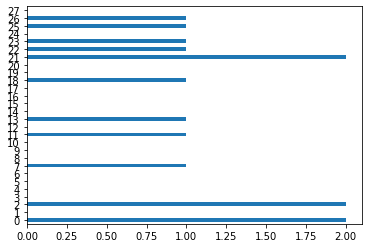

In [9]:
plt.figure()
training_set.astype(bool).sum(axis=0).plot(kind='barh')

#### Data Preprocessing

(see https://keras.io/preprocessing/image/)

This will provide real-time data augmentation later.

In [10]:
# construct the image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
              height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
              horizontal_flip=True, fill_mode="nearest")

#### Read and Process (into Keras-ready train and test sets)

In [11]:
# Based on Keras and OpenCV docs

def read_and_process(images_paths, ohe_dataframe):
    '''
    takes a panda dataframe with rows as picture IDs and columns as labels
    returns lists for keras (to be used as x and y inputs to the CNN)
    '''

    images = [] # will be used by keras as x
    labels = [] # will be used by keras as y

    for img in images_paths:
        # build image list
        images.append(cv2.imread(img, cv2.IMREAD_GRAYSCALE)) # load images using cv2.imread()

        # build labels/target/tag list
        # Check labels at each step and build labels list accordingly
        # --> order is important, the lists are meant to be zip()ed
        for idx, row in ohe_dataframe.iterrows():
            if idx in img:
                labels.append(tuple(row))
    
    return np.array(images), np.array(labels)

In [12]:
train_x, train_y = read_and_process(train_green, training_set)
# test_x,  test_y  = read_and_process(test_green, training_set)
print(train_x)
print(train_y)

[[[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  1  0 ...  0  0  0]]

 [[ 1  0  0 ...  7  0  0]
  [ 0  0  1 ...  4  3  5]
  [ 0  0  5 ...  6  2  7]
  ...
  [ 2  2  0 ...  0  1  0]
  [ 0  3  0 ...  1  2  0]
  [ 3  0  0 ...  0  7  0]]

 [[ 8 24 30 ...  0  0  0]
  [ 0  7 16 ...  0  0  0]
  [13 12  3 ...  0  0  0]
  ...
  [ 0  0  0 ... 36  0 28]
  [ 0  0  0 ... 37 25 55]
  [ 0  0  0 ... 33 22 77]]

 ...

 [[24 20 17 ... 16 14 12]
  [ 9 53 21 ... 18 13  0]
  [ 0  5 28 ... 36  3 18]
  ...
  [11  0 35 ...  0  0  0]
  [ 6  5  0 ...  0  0  0]
  [ 3  0  0 ...  1  0  0]]

 [[29 33  0 ...  0  0  0]
  [ 7 12  3 ...  0  0  0]
  [ 5  2  2 ...  0  0  0]
  ...
  [ 2 31 26 ...  9 12  2]
  [ 3 23  1 ... 10  2 28]
  [ 2 11  5 ... 12  4 30]]

 [[38 68 31 ...  6 17  0]
  [ 8 12  7 ...  3 22  2]
  [ 1  3  9 ...  1  7  0]
  ...
  [ 8 22 12 ... 88 25 24]
  [35 34  3 ...  2 34 45]
  [ 2 33 30 ... 24 19 20]]]
[[0 0 1 0 

### CNN Setup

Now that the preprocessing is out of the way, we can build our CNN structure.

#### Input Layer

Input Shape: (Label_0, Label_1, Label_1, ..., Label_27)

#### Conv + ReLU + Pool Blocks